## Preliminaries

Import data and build graph

In [1]:
import numpy as np
import pandas as pd

city = "small"

edgelist = pd.read_csv("out/" + city + ".results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


In [84]:
import networkx as nx

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)
G_undirected = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
H = nx.line_graph(G_undirected)
H.add_nodes_from((node, G_undirected.edges[node]) for node in H)

def smoothness(G, attr):
    L = nx.laplacian_matrix(G)
    x = np.array([attrs[attr] for _, attrs in G.nodes(data=True)])
    return x.transpose() @ L @ x

smoothness(H, "vehicle_speed") / H.number_of_nodes()

14.352409075907591

In [28]:
smoothness(H, "flow") / H.number_of_nodes()

8887190.131188119

## Sensor Selection

This is the fundamental greedy algorithm implementation. 

In [29]:
def get_labels_from_df(df, from_idx, to_idx, label_idx):
    labeled_edges = {}
    for e in df.itertuples():
        labeled_edges[(e[from_idx], e[to_idx])] = e[label_idx]
    return labeled_edges

In [59]:
from scipy.sparse import coo_matrix, linalg

def flow_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]

    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
    
            
    return pred_flows

In [31]:
def mse(pred_labels, labeled_edges):
    return sum((v - pred_labels[k]) ** 2 for k, v in labeled_edges.items()) / len(labeled_flows)        

In [126]:
from tqdm.notebook import tqdm
from multiprocess import Pool 
import heapq

def choose_sensors(G, labeled_edges, predict, evaluate, k=None):
    """
    Choose `k` sensors greedily to optimize the prediction given by `predict` for ground truth `labels`
    based on loss function `evaluate` (lower loss is better). 
    
    Parameters:
        -- G: networkx graph
        -- labeled_edges: dict {edge : value}
        -- predict: function taking G, labeled_edges -> prediction
        -- evaluate: prediction, true_values -> loss
    """
    if k == None:
        k = int(G.number_of_edges() / 50)
    
    sensors = []
        
    # Find value of adding each edge not in the set
    with Pool(4) as pool:
        deltas = pool.map(lambda e: (-evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges), e), labeled_edges)
        
#     deltas = []
#     for e in tqdm(labeled_edges):
#         deltas.append((-evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges), e))

    heapq.heapify(deltas)
    
    # Greedily select sensors
    for i in tqdm(range(k)):
        current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)

        # Current top 
        _, s = heapq.heappop(deltas)
        delta = current - evaluate(predict(G, 
                                           {e: labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}), 
                                   labeled_edges)

        # Next top
        delta_next, s_next = heapq.heappop(deltas)
        delta_next = current - delta_next

        # Compute change in top node
        # If the change drops it below the next best, recalculate the next best and continue
        while delta - delta_next > 1e-3:
            print("s {} delta {} s_next {} delta_next {} current {}".format(s, delta, s_next, delta_next, current))
            delta_next = current - evaluate(predict(G, 
                                 {e: labeled_edges[e] for e in sensors} | {s_next : labeled_edges[s_next]}), 
                         labeled_edges)
            if delta_next <= delta:
                heapq.heappush(deltas, (delta, s))
                delta, s = delta_next, s_next
            else:
                heapq.heappush(deltas, (delta_next, s_next))
                delta_next, s_next = heapq.heappop(deltas)

        sensors.append(s)
        
    return sensors

In [92]:
labeled_edges = get_labels_from_df(edgelist, 2, 3, -2)
choose_sensors(G, labeled_edges, flow_prediction, mse)

  0%|          | 0/24 [00:00<?, ?it/s]

[(2358067005, 540985818),
 (10559937, 326723975),
 (1832222747, 353034446),
 (353034879, 1615052989),
 (4065544424, 269459338),
 (269459315, 269459332),
 (269459293, 807592424),
 (326723913, 326723915),
 (326723915, 269459293),
 (1347515636, 268538952),
 (353034592, 353034593),
 (353034446, 353034591),
 (353034593, 353034594),
 (269461337, 269461338),
 (269460527, 269460939),
 (269461338, 269461339),
 (269459514, 269459515),
 (269460924, 269460925),
 (269460925, 269460926),
 (269460926, 269460927),
 (269461335, 269461336),
 (269461334, 269461335),
 (269461333, 269461334),
 (269459338, 269459339)]

### Testing

Should choose one node from each colored cluster

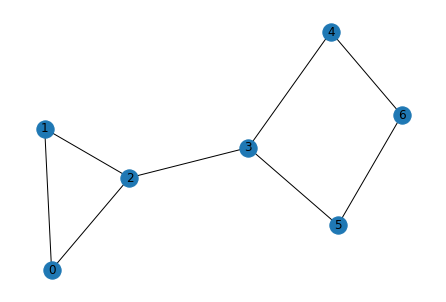

In [120]:
J = nx.Graph()

J.add_edge(0,1)
J.add_edge(1,2)
J.add_edge(0,2)
J.add_edge(2,3)
J.add_edge(3,4)
J.add_edge(3,5)
J.add_edge(4,6)
J.add_edge(5,6)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(0,2)] = -10.
flows[(2,3)] = 0.
flows[(3,4)] = -10.
flows[(3,5)] = 10.
flows[(4,6)] = -10.
flows[(5,6)] = 10.

nx.draw(J, with_labels=True)

In [121]:
choose_sensors(J, flows, flow_prediction, mse, 3)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[(2, 3), (0, 2), (3, 4)]

## Testing - Small Network

In [122]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


In [123]:
import matplotlib as mpl
import matplotlib.pyplot as plt

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

  0%|          | 0/24 [00:00<?, ?it/s]

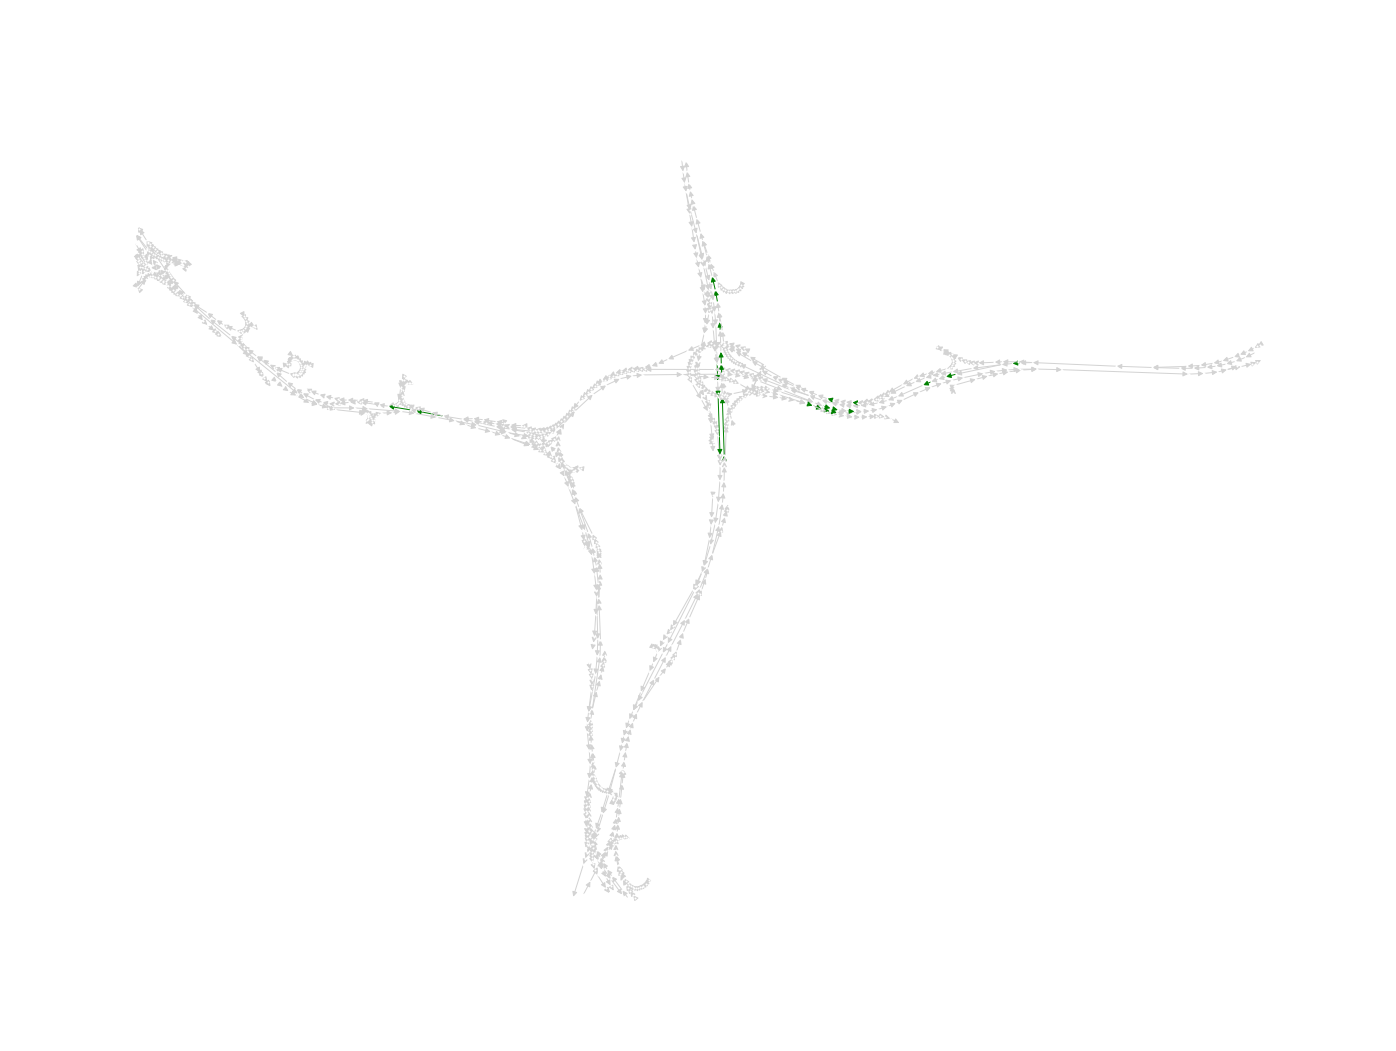

In [127]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

opt_sensors = choose_sensors(G, labeled_edges, flow_prediction, mse)
edge_colors = ["green" if (u, v) in opt_sensors or (v, u) in opt_sensors else "lightgray" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

In [ ]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

cmap = mpl.colormaps["Reds"]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=[cmap(abs(x_ - p) / (x_ + 1)) for p, x_ in zip(pred, x)])

## Benchmarks

In [ ]:
"""
Choose k highest degree nodes in the graph. 
"""
def high_degree(G, k=None):
    if k == None:
        k = int(G.number_of_nodes() / 50)
        
    return [v[0] for v in sorted(G.degree, key=lambda x: x[1], reverse=True)[:k]]

In [ ]:
J = nx.erdos_renyi_graph(10, 0.4, seed=0)
nx.draw(J, with_labels=True)

In [ ]:
high_degree(J, 3)

In [ ]:
"""
Randomly select k nodes from the graph.
"""
def random(G, k=None):
    if k == None:
        k = int(G.number_of_nodes() / 50)
        
    return np.random.choice(G.nodes, k)

In [ ]:
random(J, 2)

### TODO

Get benchmarks from active learning paper

## Error Metrics

In [ ]:
def mape(x, pred):
    return sum([abs(x_ - p) / (x_ + 1e-4) for p, x_ in zip(pred, x)]) / len(x)

In [ ]:
def mse(x, pred):
    return (np.square(pred - x)).mean()

In [ ]:
"""
Maximum error across all nodes.
"""
def max_error(error):
    return lambda x, pred: max([error(x, pred)])

In [ ]:
"""
Compute error on only a subset of nodes.
"""
def subset_error(x, pred, error, subset=None):
    
    pred_subset = np.copy(pred)
    if subset == None:
        subset = set(range(len(pred)))
    
    for i, _ in enumerate(pred):
        if i not in subset:
            pred[i] = x[i]
    
    return error(x, pred)